# **Detection with Background Subtraction**

In this notebook we will explore a simple method of moving object detection via Background Subtraction. Don't let it's apparent simplicity fool you, this approach can be used for **real applications**, plus there is some crazy math being handled by the OpenCV library.

#### Assumptions
1) Static Camera
2) Objects move smoothly across each frame (i.e. they don't move too quickly)


#### Algorithm Outline:
- Initialize Background Model
- Update Background Model with new image frame
- Obtain Foreground Mask from Background Model
- Obtain Clean Motion Mask from Foreground Mask
- Obtain initial motion detections from Motion Mask
- Perform Non-Maximal Suppression on initial motion detections
- Repeat for next frame

In [1]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from motion_detection_utils import *

### Visualize the data

We are using highway traffic scene data. The camera does not move and the cars are all moving, both of which make it ideal to obtain the background. 

Helper function to visualize images in sequence

In [2]:
# get properly sorted images
data_path = 'images_highway'
image_paths = []
for image_name in os.listdir(data_path):
    if '.jpg' in image_name:
        image_paths.append(f'{data_path}/{image_name}')

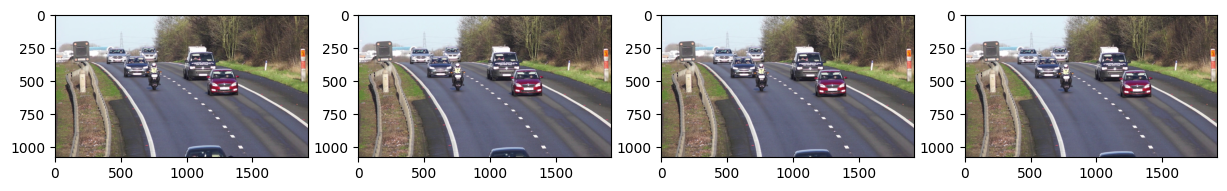

In [3]:
idx = 21

img1_rgb = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(cv2.imread(image_paths[idx+1]), cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(cv2.imread(image_paths[idx+2]), cv2.COLOR_BGR2RGB)
img4_rgb = cv2.cvtColor(cv2.imread(image_paths[idx+3]), cv2.COLOR_BGR2RGB)

# fig, ax = plt.subplots(1, 4, figsize=(150, 75))
fig, ax = plt.subplots(1, 4, figsize=(15, 7.5))
ax[0].imshow(img1_rgb)
ax[1].imshow(img2_rgb)
ax[2].imshow(img3_rgb)
ax[3].imshow(img4_rgb)
plt.show()

Perform Background subtraction between 2 frames

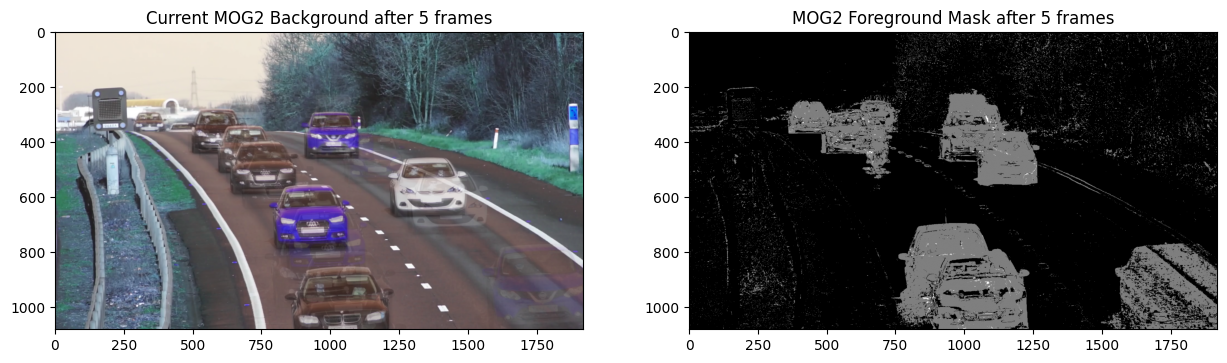

In [4]:
frame1 = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
frame2 = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)
frame3 = cv2.cvtColor(img3_rgb, cv2.COLOR_RGB2GRAY)
frame4 = cv2.cvtColor(img4_rgb, cv2.COLOR_RGB2GRAY)

# get background subtractor
sub_type = 'MOG2' # 'KNN' # 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)
    

for img_path in image_paths[:5]:
    image = cv2.imread(img_path)

    fg_mask = backSub.apply(image)


# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray') 
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")
plt.show()

In [5]:
def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 3)
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

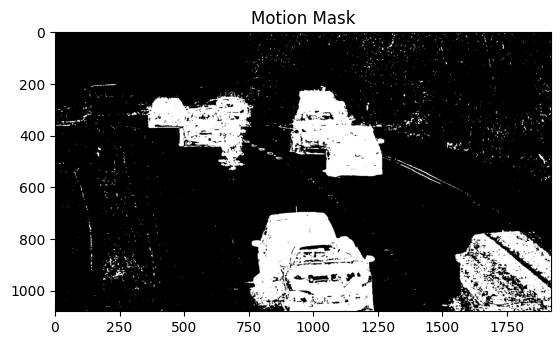

In [6]:
# fg_mask = backSub.apply(image) # only run this once!
mask = get_motion_mask(fg_mask)

plt.imshow(mask, cmap='gray')
plt.title("Motion Mask")
plt.show()

Next we will find the contours on our image mask. These contours will help find the large moving objects that we wish to detect.

Then we will use the detected contours to find the moving objects. To do this we will use the "boundingRect" function to obtain bounding box locations of the detections. You may have noticed that the image mask was not perfectly denoised, instead of denoising the image mask we will use the area of each detected bounding box as a threshold to determine the initial detectons. 

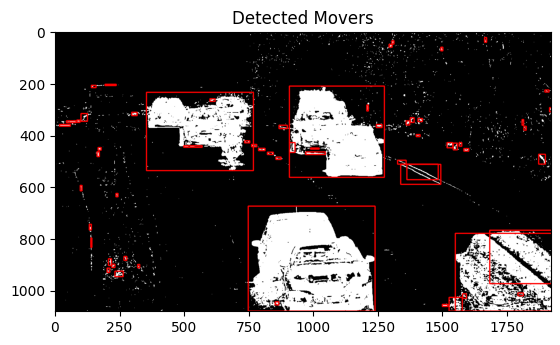

In [7]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections(mask, thresh=100)

# separate bboxes and scores
bboxes = detections[:, :4]
scores = detections[:, -1] # bbox areas

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers")
plt.show()

## **Perform Non-Maximal Suppression**

In [8]:
nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(62, 49)

Now we will draw our final detections on the image

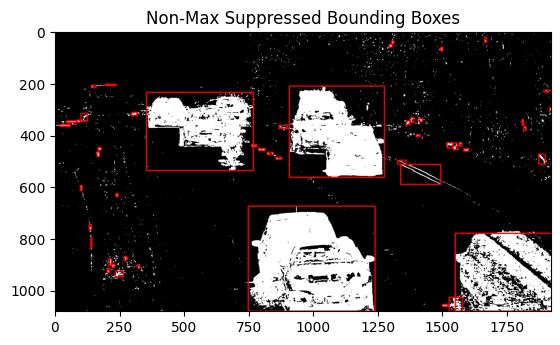

In [10]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes")
plt.show()

## **Get Detection Pipeline**

In [11]:
def get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=np.array((9,9), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            backSub - Background Subtraction Model
            frame - Current BGR Frame
            bbox_thresh - Minimum threshold area for declaring a bounding box
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # Update Background Model and get foreground mask
    fg_mask = backSub.apply(frame)

    # get clean motion mask
    motion_mask = get_motion_mask(fg_mask, kernel=kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, bbox_thresh)

    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, nms_thresh)
    

Test the main pipeline and draw the detections on frame 2

In [13]:
video_frames = []

kernel=np.array((9,9), dtype=np.uint8)

sub_type = 'KNN' # 'MOG2' # 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

for idx in range(0, len(image_paths)):
    # read frames
    frame_bgr = cv2.imread(image_paths[idx])

    # get detections
    detections = get_detections(backSub, 
                                frame_bgr, # cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY), 
                                bbox_thresh=100, 
                                nms_thresh=1e-2, 
                                kernel=kernel)
                                
    # draw bounding boxes on frame
    draw_bboxes(frame_bgr, detections)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(frame_bgr)
    plt.axis('off')
    # fig.savefig(f"temp/frame_{idx}.png")
    plt.close()

    # OPTIONAL append to list for video
    video_frames.append(frame_bgr)

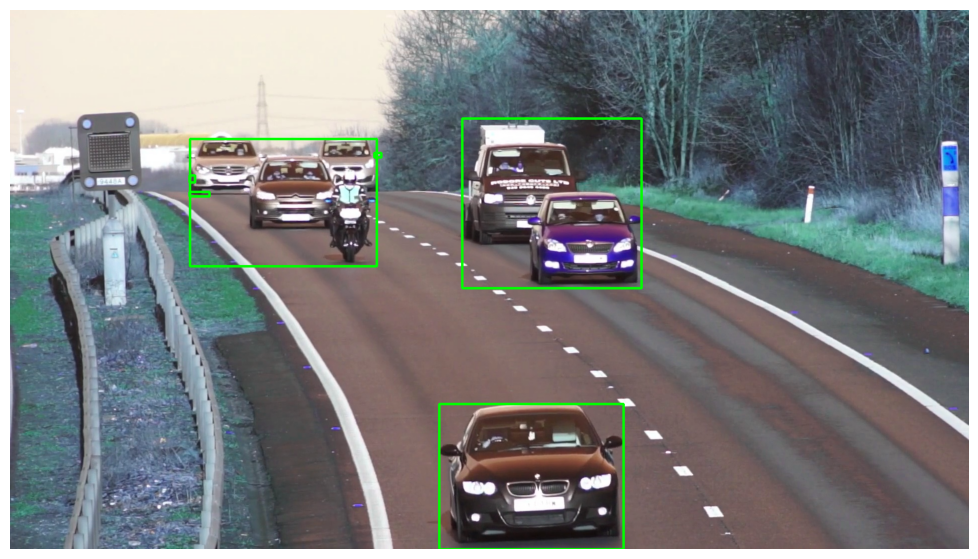

In [14]:
plt.imshow(frame_bgr)
plt.show()

##### Display Final Background Models

In [16]:
mog2_background = backSub.getBackgroundImage()
knn_background = backSub.getBackgroundImage()

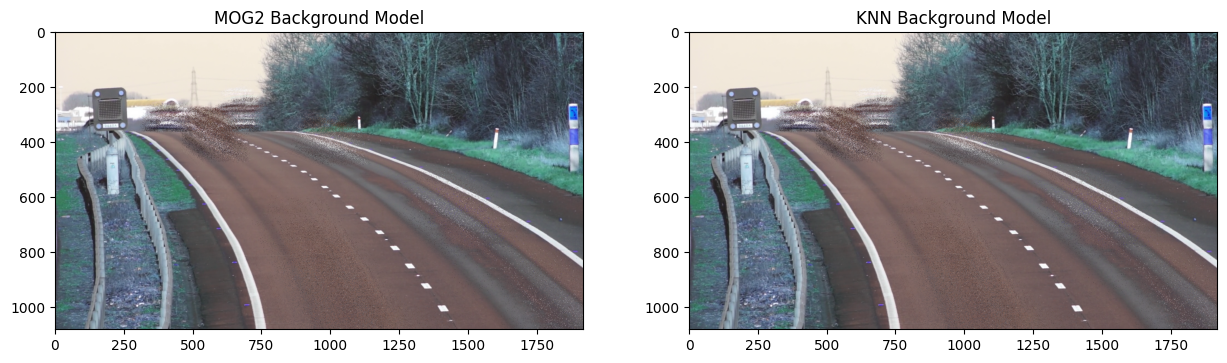

In [17]:
# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mog2_background)
ax[0].set_title(f"MOG2 Background Model")
ax[1].imshow(knn_background) 
ax[1].set_title(f"KNN Background Model")
plt.show()

### Make GIF

In [100]:
create_gif_from_images(f"background_subtraction_{sub_type}.GIF", 'temp', '.png')

### OPTIONAL: Make Video

In [85]:
out = cv2.VideoWriter(f"background_subtraction_{sub_type}.mp4", cv2.VideoWriter_fourcc(*'MP4V'), 25, (1920, 1080))

for img in video_frames:
    out.write(img)

out.release()
del out

In [142]:
backSub.getShadowThreshold()

0.75

In [134]:
backSub.setShadowThreshold(0.75)

In [135]:
backSub.getShadowThreshold()

0.75